# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [202]:
import warnings
warnings.filterwarnings('ignore')

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [183]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ:** метод predict_proba возвращает вероятности принадлежности к положительному классу

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


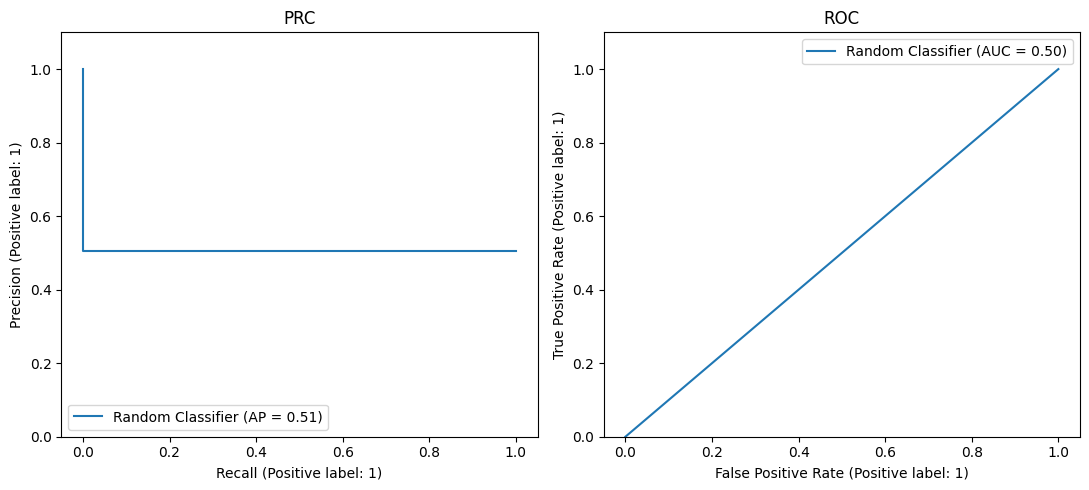

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
from sklearn.svm import LinearSVC

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [9]:
c_space = {'C':np.logspace(-10, 10, 20)}
from sklearn.metrics import make_scorer

def auc_pr_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

auc_pr_scorer = make_scorer(auc_pr_score, greater_is_better=True)

model = LinearSVC(dual="auto", random_state=42)
grid_search = GridSearchCV(model, c_space, cv=5, scoring=auc_pr_scorer)

grid_search.fit(X_train, y_train)

best_c_SVM = grid_search.best_params_['C']
print("Best C =" , best_c_SVM)
print("Best score =", grid_search.best_score_)

Best C = 0.002335721469090121
Best score = 0.8393585793404595


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [10]:
def normalize(decision_func):
    return (decision_func - decision_func.min()) / (decision_func.max() - decision_func.min())

SVM Classifier metrics
AUC-PR: 0.82755
AUC-ROC: 0.84692


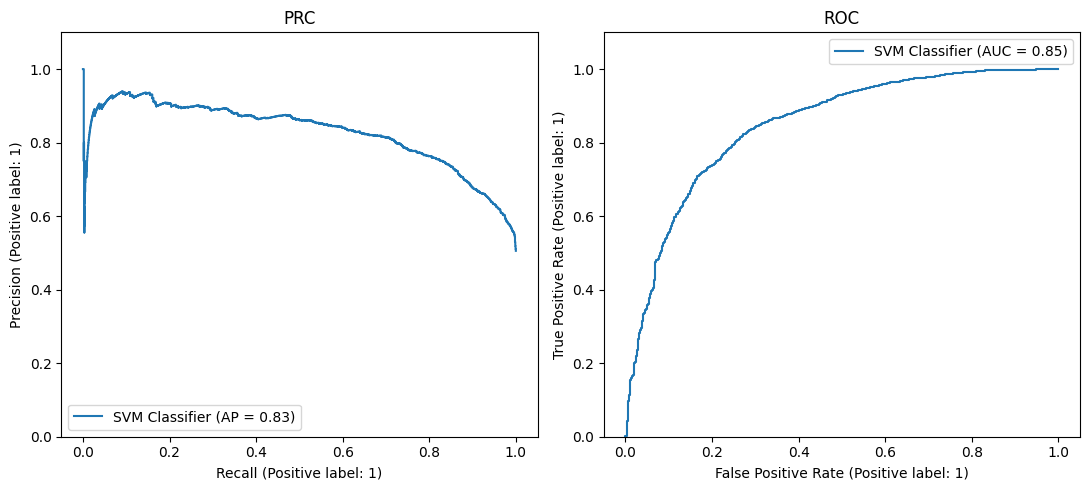

In [11]:
y_svm = normalize(grid_search.decision_function(X_test))
depict_pr_roc(y_test, y_svm, classifier_name='SVM Classifier')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [12]:
df_metrics.loc['SVM Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_svm),
      best_c_SVM
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
SVM Classifier,0.752833,0.846922,0.002336


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
c_space = {'C':np.logspace(-10, 10, 20)}

def auc_pr_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

auc_pr_scorer = make_scorer(auc_pr_score, greater_is_better=True)

model = LogisticRegression()
grid_search = GridSearchCV(model, c_space, cv=5, scoring=auc_pr_scorer)

grid_search.fit(X_train, y_train)

best_c_LogReg = grid_search.best_params_['C']
print("Best C =" , best_c_LogReg)
print("Best score =", grid_search.best_score_)



Best C = 0.002335721469090121
Best score = 0.8403939408335199


In [15]:
model = LogisticRegression(C=best_c_LogReg)
model.fit(X_train, y_train)
y_logreg = model.predict_proba(X_test)[:, 1]

Logistic Regression metrics
AUC-PR: 0.83093
AUC-ROC: 0.84589


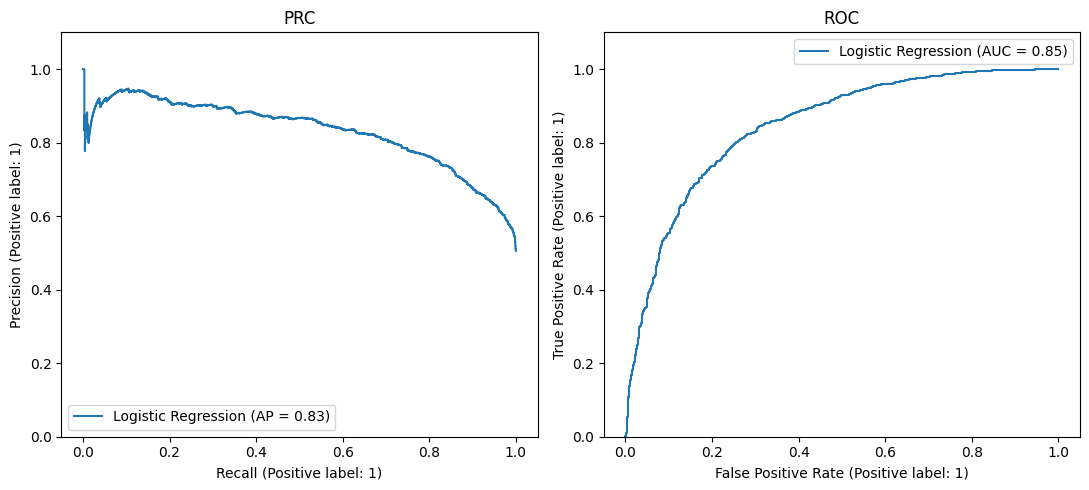

In [16]:
depict_pr_roc(y_test, y_logreg, classifier_name='Logistic Regression')

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
SVM Classifier metrics
AUC-PR: 0.82755
AUC-ROC: 0.84692
Logistic Regression metrics
AUC-PR: 0.83093
AUC-ROC: 0.84589


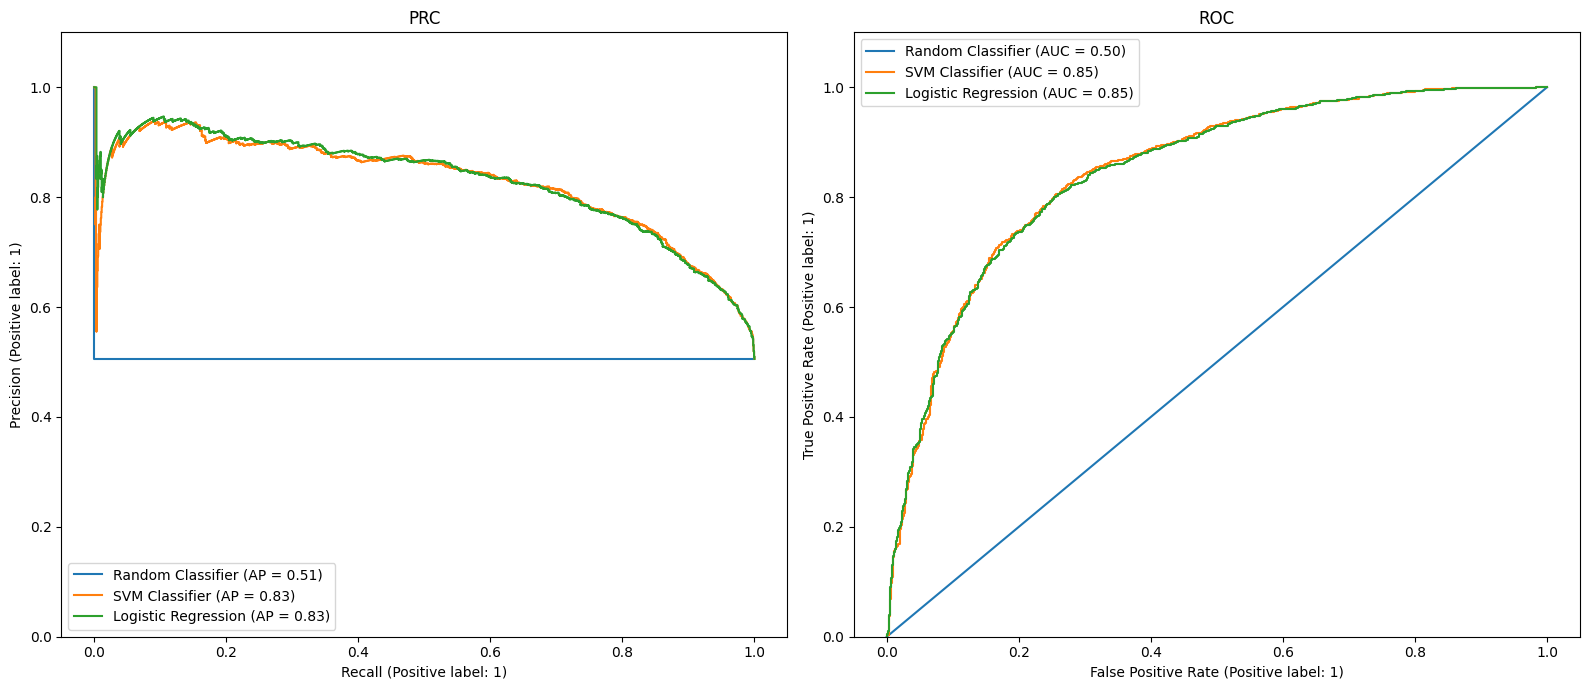

In [17]:
f, ax = plt.subplots(1, 2, figsize=(16, 7))
depict_pr_roc(y_test, y_random, 'Random Classifier', ax=ax)
depict_pr_roc(y_test, y_svm, classifier_name='SVM Classifier', ax=ax)
depict_pr_roc(y_test, y_logreg, classifier_name='Logistic Regression', ax=ax)


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



In [18]:
df_metrics.loc['Logistic Regression Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_logreg),
      best_c_LogReg
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
SVM Classifier,0.752833,0.846922,0.002336
Logistic Regression Classifier,0.752833,0.845888,0.002336


**Ответ:** SVM сработал чуть лучше с точки зрения AUC-ROC

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [19]:
from sklearn.svm import SVC

In [20]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
model = SVC(C=best_c_SVM, kernel='linear', gamma='auto', random_state=42)
model.fit(X_train, y_train)

SVC(C=0.002335721469090121, gamma='auto', kernel='linear', random_state=42)

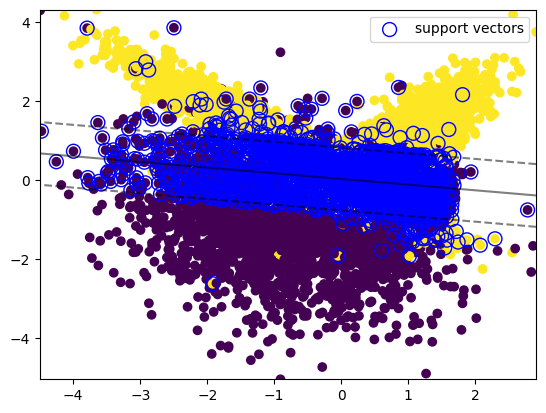

In [22]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(30, 30)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y)

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Опорными выделяются объекты, "расстояние" от которых до разделяющей гиперплоскости превышает отступ.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [23]:
model = LogisticRegression(C=best_c_LogReg)
model.fit(X_train, y_train)

LogisticRegression(C=0.002335721469090121)

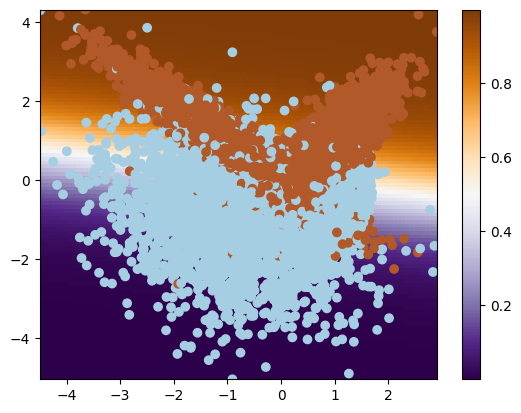

In [25]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1].reshape((100, 100)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** данная область - окрестность разделяющей гиперплоскости + она сама. Чем модуль скалярного проиведения объекта и весов больше, тем больше мы уверены. Чем менее уверены, тем ближе значение predict_proba к 0.5 (функция сигмоиды). А точки, в которых модуль скалярного проиведения объекта и весов больше маленький, ближе находятся к разделяющей гиперплоскости.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [26]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = i * 1.0 / n_bins
        r = (i+1) * 1.0 / n_bins
        bin_middle_points.append((r + l) / 2)
        bin_real_ratios.append(np.sum(y_test * np.where((preds >= l) & (preds < r), 1, 0))/np.sum(np.where((preds >= l) & (preds < r), 1, 0)))

    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot([0,1], [0,1], '--')
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [27]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=777)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777)

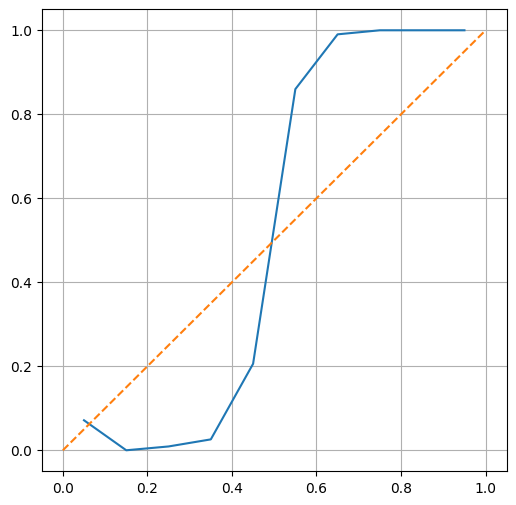

In [28]:
model = SVC(C=best_c_SVM, kernel='linear', gamma='auto', random_state=777, probability=True)
model.fit(X_train, y_train)
y_pred_decision_svc = model.decision_function(X_test)

y_pred_svc = model.predict(X_test)
plot_calibration_curve(y_test, normalize(y_pred_decision_svc))
plt.show()

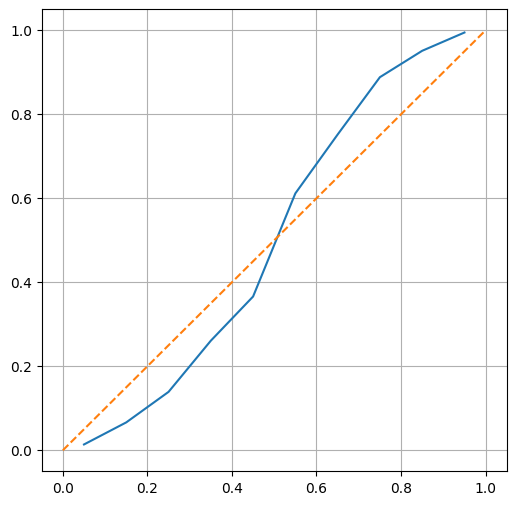

In [29]:
model = LogisticRegression(C=best_c_LogReg)
model.fit(X, y)
y_pred_proba_logreg = model.predict_proba(X_test)[:, 1]

y_pred_logreg = model.predict(X_test)
plot_calibration_curve(y_test, y_pred_proba_logreg)
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** для логистической регрессии лучше, чем для SVM

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

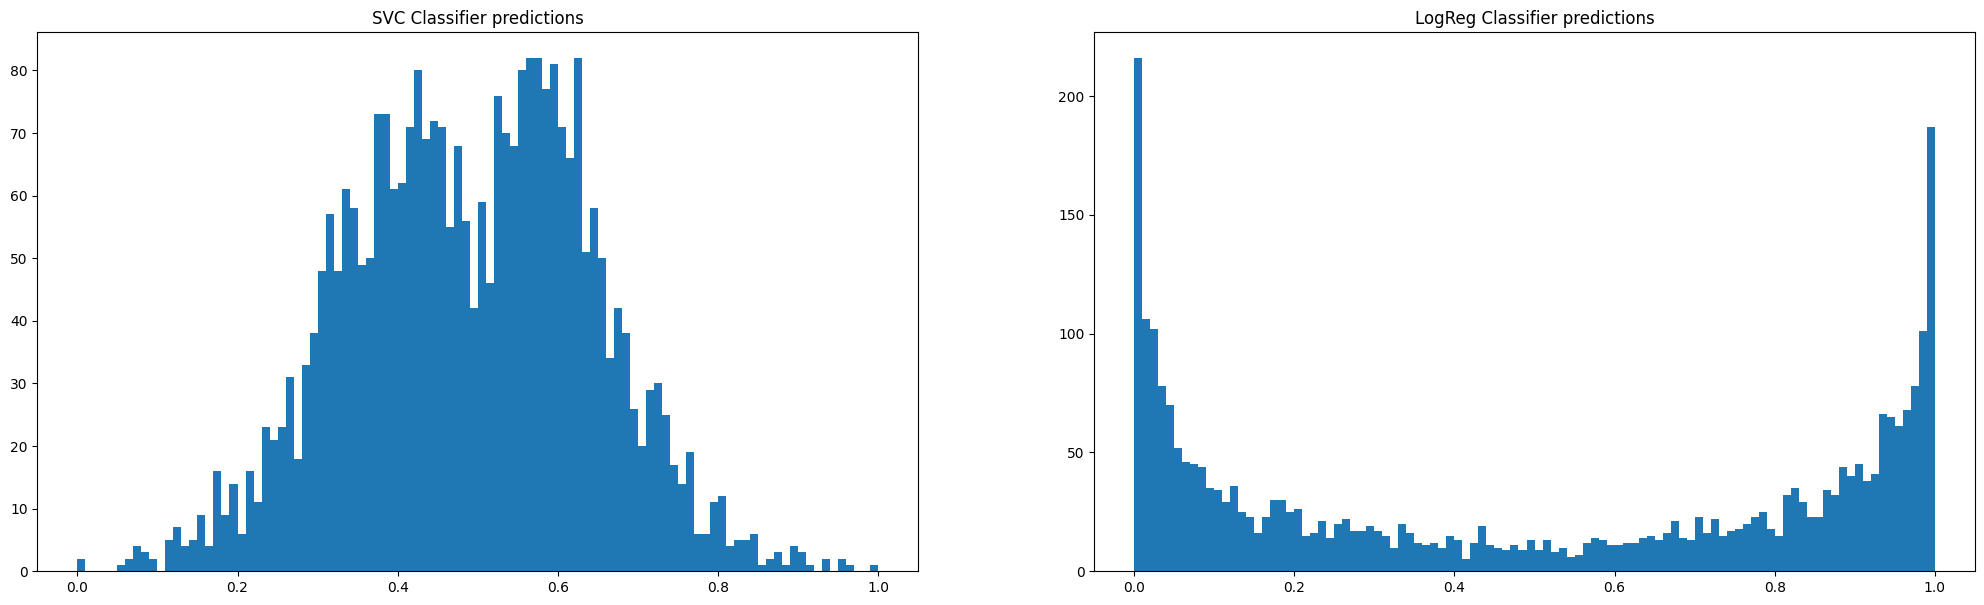

In [30]:
f, ax = plt.subplots(1, 2, figsize=(25, 7))
ax[0].hist(normalize(y_pred_decision_svc), bins=100)
ax[1].hist(y_pred_proba_logreg, bins=100)

ax[0].set_title('SVC Classifier predictions')
ax[1].set_title('LogReg Classifier predictions')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** предсказанные вероятности у SVM распределены примерно нормально. Это можно объяснить тем, что в методе опорных векторов работая с линейно неразделимыми данными мы хотим впихнуть разделяющую гиперплоскость так, чтобы большая часть одного класса была с одной стороны, а другого с другой. Тут мы анализируем уверенность модели в предсказаниях и неуверенность соответствует 0.5 - пику гауссианы, объектам, которые оказались ближе всего к разделителю. Поскольку данные неразделимы, таких объектов много, а тех, в ком мы уверены - мало. При другом seed получится одна гауссиана (тут две), но смысл тот же. Логистическая регрессия нацелена на корректное предсказания вероятностей, поэтому предсказаний, близких к 0.5, оказалось меньше. Однако не всегда сработает так хорошо, это так же зависит от даннных.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [31]:
from sklearn.calibration import CalibratedClassifierCV

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


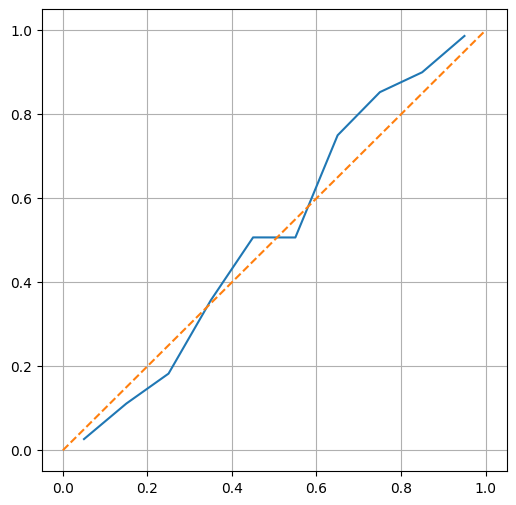

In [33]:
model = SVC(kernel='linear', C=best_c_SVM).fit(X_train, y_train)
calibrated_svm = CalibratedClassifierCV(model, cv='prefit').fit(X_val, y_val)
y_pred = calibrated_svm.predict_proba(X_test)[:,1]

plot_calibration_curve(y_test, y_pred)
# plt.hist(y_pred, bins=100)
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** да!!!

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [98]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [74]:
df = pd.read_csv('archive/bike_buyers.csv')
df

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0,Yes
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0,Yes
997,11809,Married,NaN,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0,Yes
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0,No


In [75]:
df.isna().sum()

ID                   0
Marital Status       7
Gender              11
Income               6
Children             8
Education            0
Occupation           0
Home Owner           4
Cars                 9
Commute Distance     0
Region               0
Age                  8
Purchased Bike       0
dtype: int64

In [76]:
df.columns

Index(['ID', 'Marital Status', 'Gender', 'Income', 'Children', 'Education',
       'Occupation', 'Home Owner', 'Cars', 'Commute Distance', 'Region', 'Age',
       'Purchased Bike'],
      dtype='object')

In [77]:

#Заменим пропуски категориальных переменных
categorical_nans = ['Marital Status', 'Gender', 'Home Owner']
df[categorical_nans] = df[categorical_nans].fillna('undefined')

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = X[['Income','Children', 'Cars', 'Age']]
X_categorical = X[['Marital Status', 'Gender', 'Education',
       'Occupation', 'Home Owner', 'Commute Distance', 'Region']]

In [78]:
df

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,undefined,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0,Yes
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0,Yes
997,11809,Married,undefined,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0,Yes
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0,No


В начале поработаем только с категориальными признаками

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [80]:
from sklearn.preprocessing import OrdinalEncoder
from time import time
start = time()
ordenc = OrdinalEncoder()
X_train_trans = ordenc.fit_transform(X_train)
X_test_trans = ordenc.transform(X_test)
model = LogisticRegression()
model.fit(X_train_trans, y_train)
y_pred_ordenc = model.predict_proba(X_test_trans)[:, 1]
end = time()

precision, recall, _ = precision_recall_curve(y_test, y_pred_ordenc)
print('time elapced: %.5f' % (end-start), 'AUC-PR: %.5f' % auc(recall, precision))



time elapced: 0.01009 AUC-PR: 0.57894


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [81]:
from sklearn.preprocessing import OneHotEncoder

start = time()
oheenc = OneHotEncoder()
X_train_trans = oheenc.fit_transform(X_train)
X_test_trans = oheenc.transform(X_test)
model = LogisticRegression()
model.fit(X_train_trans, y_train)
y_pred_oheenc = model.predict_proba(X_test_trans)[:, 1]
end = time()

precision, recall, _ = precision_recall_curve(y_test, y_pred_oheenc)
print('time elapced: %.5f' % (end-start), 'AUC-PR: %.5f' % auc(recall, precision))



time elapced: 0.01778 AUC-PR: 0.66186


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [82]:
from collections import defaultdict as dd

In [83]:
class MeanTargetEncoder:
    def __init__(self):
        self.encode = dd()

    def fit_transform(self, X, y):
        data = X.copy()
        for feature in X.columns:
            self.encode[feature] = dd()
            categories = X[feature].unique().tolist()
            idx_groups = X.groupby(feature).indices
            for cat in categories:
                self.encode[feature][cat] = y.iloc[idx_groups[cat]].mean()
                data.loc[data[feature]==cat, feature] = self.encode[feature][cat]
        return data
    
    def transform(self, X):
        data = X.copy()
        for feature in self.encode.keys():
            for cat in self.encode[feature].keys():
                data.loc[data[feature]==cat, feature] = self.encode[feature][cat]
        return data

In [84]:
start = time()
mtargetenc = MeanTargetEncoder()
X_train_trans = mtargetenc.fit_transform(X_train, y_train)
X_test_trans = mtargetenc.transform(X_test)
model = LogisticRegression()
model.fit(X_train_trans, y_train)
y_pred_mtargetenc = model.predict_proba(X_test_trans)[:,1]
end = time()

precision, recall, _ = precision_recall_curve(y_test, y_pred_mtargetenc)
print('time elapced: %.5f' % (end-start), 'AUC-PR: %.5f' % auc(recall, precision))



time elapced: 0.03937 AUC-PR: 0.65269


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin
class MeanTargetEncoderOpt(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encode = dd(dict)
    def fit(self, X):
        data = X.copy()
        for feature in X.columns:
            self.encode[feature] = dict(data.groupby(feature)['Purchased Bike'].mean())
        return self
    
    def fit_transform(self, X):
        data = X.copy()
        for feature in X.columns:
            self.encode[feature] = dict(data.groupby(feature)['Purchased Bike'].mean())
            data[feature] = data[feature].map(self.encode[feature])
        return data.drop(columns=['Purchased Bike'])
    
    def transform(self, X):
        data = X.copy()
        for feature in X.columns:
            data[feature] = data[feature].map(self.encode[feature])
        return data

In [86]:
start = time()
mtargetenc = MeanTargetEncoderOpt()
X_train_trans = mtargetenc.fit_transform(pd.concat([X_train, y_train], axis=1))
X_test_trans = mtargetenc.transform(X_test)
model = LogisticRegression()
model.fit(X_train_trans, y_train)
y_pred_mtargetenc = model.predict_proba(X_test_trans)[:,1]
end = time()
precision, recall, _ = precision_recall_curve(y_test, y_pred_mtargetenc)
print('time elapced: %.5f' % (end-start), 'AUC-PR: %.5f' % auc(recall, precision))

time elapced: 0.01760 AUC-PR: 0.65269


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [87]:
import scipy.stats as st

In [88]:
class MeanTargetEncoderNoisy:
    def __init__(self):
        self.encode = dd()

    def fit_transform(self, X, y):
        data = X.copy()
        for feature in X.columns:
            self.encode[feature] = dd()
            categories = X[feature].unique().tolist()
            idx_groups = X.groupby(feature).indices
            for cat in categories:
                self.encode[feature][cat] = y.iloc[idx_groups[cat]].mean() + st.norm.rvs(0, 0.01)
                data.loc[data[feature]==cat, feature] = self.encode[feature][cat] 
        return data
    
    def transform(self, X):
        data = X.copy()
        for feature in self.encode.keys():
            for cat in self.encode[feature].keys():
                data.loc[data[feature]==cat, feature] = self.encode[feature][cat]
        return data

In [89]:
start = time()
mtargetenc = MeanTargetEncoderNoisy()
X_train_trans = mtargetenc.fit_transform(X_train, y_train)
X_test_trans = mtargetenc.transform(X_test)
model = LogisticRegression()
model.fit(X_train_trans, y_train)
y_pred_mtargetenc = model.predict_proba(X_test_trans)[:,1]
end = time()

precision, recall, _ = precision_recall_curve(y_test, y_pred_mtargetenc)
print('time elapced: %.5f' % (end-start), 'AUC-PR: %.5f' % auc(recall, precision))



time elapced: 0.04056 AUC-PR: 0.65644


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** с практической точки зрения помогло, мы избавились от утечки таргета (по крайней мере попытались), однако с точки зрения качества предсказаний все не очень хорошо, потому что запукая обучение несколько раз мы можем получить совсем разные результаты


##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [90]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [91]:
class MeanTargetEncoderSmooth:
    def __init__(self, c):
        self.encode = dd()
        self.C = c

    def fit_transform(self, X, y):
        data = X.copy()
        global_mean = y.mean()
        for feature in X.columns:
            self.encode[feature] = dd()
            categories = X[feature].unique().tolist()
            idx_groups = X.groupby(feature).indices
            for cat in categories:
                self.encode[feature][cat] = (y.iloc[idx_groups[cat]].sum() + self.C * global_mean) / (y.iloc[idx_groups[cat]].sum() + self.C) + st.norm.rvs(0, 0.01)
                data.loc[data[feature]==cat, feature] = self.encode[feature][cat]
        return data
    
    def transform(self, X):
        data = X.copy()
        for feature in self.encode.keys():
            for cat in self.encode[feature].keys():
                data.loc[data[feature]==cat, feature] = self.encode[feature][cat]
        return data

In [92]:
c_space = np.arange(0, 20, 0.5)
auc_pr_metrics = []
time_elapced = []
for c in c_space:
    start = time()
    mtargetenc = MeanTargetEncoderSmooth(c)
    X_train_trans = mtargetenc.fit_transform(X_train, y_train)
    X_test_trans = mtargetenc.transform(X_test)
    model = LogisticRegression()
    model.fit(X_train_trans, y_train)
    y_pred_mtargetenc = model.predict_proba(X_test_trans)[:,1]
    end = time()
    precision, recall, _ = precision_recall_curve(y_test, y_pred_mtargetenc)
    auc_pr, t = auc(recall, precision), end-start
    auc_pr_metrics.append(auc_pr)
    time_elapced.append(t)

best_C = c_space[np.argmax(auc_pr_metrics)]
print('time elapced: %.5f' % time_elapced[np.argmax(auc_pr_metrics)], 'best C: %.5f' % best_C, 'AUC-PR: %.5f' % np.max(auc_pr_metrics))


time elapced: 0.03569 best C: 9.50000 AUC-PR: 0.67914


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [93]:
numeric = X_numerical.columns
for feature in numeric:
    value = df[feature].mean()
    df[feature].fillna(value, inplace=True)

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=777, stratify=y)

In [95]:
categorical_features = X_categorical.columns.tolist()
for feature in X_numerical.columns:
    start = time()
    mtargetenc = MeanTargetEncoderSmooth(best_C)
    X_train_trans = mtargetenc.fit_transform(X_train[categorical_features + [feature]], y_train)
    X_test_trans = mtargetenc.transform(X_test[categorical_features + [feature]])
    model = LogisticRegression()
    model.fit(X_train_trans, y_train)
    y_pred_mtargetenc = model.predict_proba(X_test_trans)[:,1]
    end = time()

    precision, recall, _ = precision_recall_curve(y_test, y_pred_mtargetenc)
    print('time elapced: %.5f' % (end-start), 'AUC-PR: %.5f' % auc(recall, precision), 'numeric feature included: ', feature)



time elapced: 0.05437 AUC-PR: 0.66818 numeric feature included:  Income
time elapced: 0.04286 AUC-PR: 0.67471 numeric feature included:  Children
time elapced: 0.04641 AUC-PR: 0.68693 numeric feature included:  Cars
time elapced: 0.06439 AUC-PR: 0.61812 numeric feature included:  Age


In [96]:
start = time()
mtargetenc = MeanTargetEncoderSmooth(best_C)
X_train_trans = mtargetenc.fit_transform(X_train[categorical_features + X_numerical.columns.tolist()], y_train)
X_test_trans = mtargetenc.transform(X_test[categorical_features + X_numerical.columns.tolist()])
model = LogisticRegression()
model.fit(X_train_trans, y_train)
y_pred_mtargetenc = model.predict_proba(X_test_trans)[:,1]
end = time()

precision, recall, _ = precision_recall_curve(y_test, y_pred_mtargetenc)
print('time elapced: %.5f' % (end-start), 'AUC-PR: %.5f' % auc(recall, precision))


time elapced: 0.08641 AUC-PR: 0.65929


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Основной минус, конечно, в том, что счетчики допускают утечку таргета, причем вроде как нет способа полностью от этого избавиться, такой способ это подразумевает. Плюс в том, что количество признаков не растет со скоростью света (не растет в принципе). 

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [97]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-21 15:44:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… ошибка: nodename nor servname provided, or not known.
wget: не удаётся разрешить адрес «archive.ics.uci.edu»


In [98]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [99]:
X = df.drop(columns=['income'])
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=777,
                                                    stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [100]:
categorical = ['workclass', 'education', 'marital-status', 'occupation',
           'relationship', 'race', 'sex','native-country']
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [101]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from time import time

In [102]:
encoder = OneHotEncoder(sparse_output=False)
X_train_trans = pd.DataFrame(encoder.fit_transform(X_train[categorical]),columns=encoder.get_feature_names_out(input_features=categorical)).reset_index()
X_test_trans = pd.DataFrame(encoder.transform(X_test[categorical]),columns=encoder.get_feature_names_out(input_features=categorical)).reset_index()

X_train_encoded = pd.concat([X_train[numeric].reset_index(), X_train_trans], axis=1)
X_test_encoded = pd.concat([X_test[numeric].reset_index(), X_test_trans], axis=1)

In [103]:

start = time()
model = LogisticRegression()
model.fit(X_train_encoded, y_train)
y_pred = model.predict_proba(X_test_encoded)[:,1]
end = time()
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('time elapced: %.5f' % (end-start), 'AUC-PR: %.5f' % auc(recall, precision))



time elapced: 0.32797 AUC-PR: 0.47902


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [104]:

ind = np.sort(np.argsort(np.abs(model.coef_[0]))[-40:])
X_train_encoded = X_train_encoded[X_train_encoded.columns[ind]]
X_test_encoded = X_test_encoded[X_test_encoded.columns[ind]]


In [105]:
model = LogisticRegression()
model.fit(X_train_encoded, y_train)
y_pred = model.predict_proba(X_test_encoded)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.48761


Изменилось ли качество? Как? сильно возросло!

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [107]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

simple_pipeline = Pipeline([
    ('ohe_scaling', column_transformer),
    ('regression', LogisticRegression())
])

model = simple_pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]


precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.76712


/Users/annal/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [108]:
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(encoder.fit_transform(X_train[categorical])),columns=encoder.get_feature_names_out(input_features=categorical))
X_test_scaled = pd.DataFrame(scaler.transform(encoder.transform(X_test[categorical])),columns=encoder.get_feature_names_out(input_features=categorical))

X_train_scaled[numeric] = scaler.fit_transform(X_train[numeric])
X_test_scaled[numeric] = scaler.transform(X_test[numeric])

model = LogisticRegression().fit(X_train_scaled, y_train)
y_pred = model.predict_proba(X_test_scaled)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.76607


In [109]:

ind = np.sort(np.argsort(np.abs(model.coef_[0]))[-40:])
X_train_best = X_train_scaled[X_train_scaled.columns[ind]]
X_test_best = X_test_scaled[X_test_scaled.columns[ind]]


model = LogisticRegression().fit(X_train_best, y_train)
y_pred = model.predict_proba(X_test_best)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.76109


/Users/annal/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [110]:
def t_40(X, y):
    data = pd.concat((X, y), axis=1)

    mu1 = data.loc[data['income'] == 1].mean()
    mu0 = data.loc[data['income'] == 0].mean()
    n1 = data.loc[data['income'] == 1].count()
    n0 = data.loc[data['income'] == 0].count()
    sigma1 = data.loc[data['income'] == 1].var()
    sigma0 = data.loc[data['income'] == 0].var()

    stats = np.abs(mu1-mu0)/np.sqrt((n1*sigma1 + n0*sigma0)/n1+n0)
    stats = stats.drop('income')
    return stats.sort_values(ascending=False)[:40].index


new_categories = t_40(X_train_encoded, y).tolist()


In [113]:


model = LogisticRegression().fit(X_train_encoded[new_categories], y_train)
y_pred = model.predict_proba(X_test_encoded[new_categories])[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.47902


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [114]:
X_train_main, X_train_test, y_train_main, y_train_test = train_test_split(X_train, y_train, train_size=0.7, stratify=y_train)

In [115]:
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
X_train_main_encoded = pd.DataFrame(encoder.fit_transform(X_train_main[categorical]),columns=encoder.get_feature_names_out(input_features=categorical))
X_train_test_encoded = pd.DataFrame(encoder.transform(X_train_test[categorical]),columns=encoder.get_feature_names_out(input_features=categorical))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical]),columns=encoder.get_feature_names_out(input_features=categorical))


In [116]:
X_train_main_encoded[numeric] = scaler.fit_transform(X_train_main[numeric])
X_train_test_encoded[numeric] = scaler.transform(X_train_test[numeric])
X_test_encoded[numeric] = scaler.transform(X_test[numeric])

In [158]:

while len(X_train_main_encoded.columns) > 40:
    scores = []
    columns = X_train_main_encoded.columns
    for feature in columns:
        # without feature
        model = LogisticRegression(max_iter=1000).fit(X_train_main_encoded.drop(columns=[feature]), y_train_main)
        y_pred = model.predict_proba(X_train_test_encoded.drop(columns=[feature]))[:, 1]
        precision, recall, _ = precision_recall_curve(y_train_test, y_pred)
        scores.append(auc(recall, precision))
    X_train_main_encoded.drop(columns=columns[np.argmax(scores)], inplace=True)
    X_train_test_encoded.drop(columns=columns[np.argmax(scores)], inplace=True)
    print('Exclude: ', columns[np.argmax(scores)], np.max(scores))
    

Exclude:  native-country_ China 0.7601257355762447
Exclude:  native-country_ Italy 0.7606458460741133
Exclude:  native-country_ England 0.76086897232069
Exclude:  native-country_ France 0.7610567528540366
Exclude:  native-country_ Iran 0.7612362226068458
Exclude:  native-country_ Japan 0.761404593812993
Exclude:  native-country_ South 0.761584829986323
Exclude:  native-country_ Canada 0.7617534754467996
Exclude:  native-country_ Cuba 0.7619105213533675
Exclude:  education_ 10th 0.7620394827824268
Exclude:  marital-status_ Married-civ-spouse 0.7621680179032995
Exclude:  marital-status_ Widowed 0.7623343495274055
Exclude:  relationship_ Wife 0.7625342875519651
Exclude:  marital-status_ Married-spouse-absent 0.7626983859985379
Exclude:  occupation_ Prof-specialty 0.762814533537921
Exclude:  occupation_ Adm-clerical 0.7632944599251793
Exclude:  education_ 9th 0.763386228268764
Exclude:  workclass_ Self-emp-inc 0.763454730686111
Exclude:  workclass_ State-gov 0.763854896153241
Exclude:  edu

In [162]:
model = LogisticRegression().fit(X_train_main_encoded, y_train_main)
y_pred = model.predict_proba(X_test_encoded[X_train_main_encoded.columns.tolist()])[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc(recall, precision)

0.7185741806705532

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
X_train_main_encoded = pd.DataFrame(encoder.fit_transform(X_train_main[categorical]),columns=encoder.get_feature_names_out(input_features=categorical))
X_train_test_encoded = pd.DataFrame(encoder.transform(X_train_test[categorical]),columns=encoder.get_feature_names_out(input_features=categorical))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical]),columns=encoder.get_feature_names_out(input_features=categorical))

X_train_main_encoded[numeric] = scaler.fit_transform(X_train_main[numeric])
X_train_test_encoded[numeric] = scaler.transform(X_train_test[numeric])
X_test_encoded[numeric] = scaler.transform(X_test[numeric])

In [164]:
columns = X_train_main_encoded.columns.tolist()

In [165]:
score_pred = 0
score = 0

columns_include = []
while len(columns_include) < 40:
    scores = []
    for feature in columns:
        # without feature
        model = LogisticRegression(max_iter=1000).fit(X_train_main_encoded[columns_include + [feature]], y_train_main)
        y_pred = model.predict_proba(X_train_test_encoded[columns_include + [feature]])[:, 1]
        precision, recall, _ = precision_recall_curve(y_train_test, y_pred)
        scores.append(auc(recall, precision))

    score_pred = score
    score = np.max(scores)
    print('Include: ', columns[np.argmax(scores)], score)
    columns_include.append(columns[np.argmax(scores)])
    columns.remove(columns[np.argmax(scores)])
    
    
    

Include:  marital-status_ Married-civ-spouse 0.667428921837963
Include:  occupation_ Other-service 0.6710772855074243
Include:  occupation_ Farming-fishing 0.6747865174224741
Include:  education_ 7th-8th 0.678252997373794
Include:  relationship_ Own-child 0.6805453795015322
Include:  education_ 9th 0.6826929673031867
Include:  education_ 11th 0.6847793754030522
Include:  capital-gain 0.6876541963548027
Include:  education-num 0.7343488401241689
Include:  capital-loss 0.7440026545042431
Include:  hours-per-week 0.7487250604633625
Include:  occupation_ Exec-managerial 0.7524038738372347
Include:  age 0.7551205571684882
Include:  workclass_ Federal-gov 0.7560531669645045
Include:  native-country_ United-States 0.7566892534439196
Include:  relationship_ Other-relative 0.7572915392925181
Include:  occupation_ Tech-support 0.7577554752282712
Include:  marital-status_ Never-married 0.7582575631807211
Include:  occupation_ Protective-serv 0.7586971374169956
Include:  native-country_ Germany 0.

In [167]:
model = LogisticRegression().fit(X_train_main_encoded[columns_include], y_train_main)
y_pred = model.predict_proba(X_test_encoded[columns_include])[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc(recall, precision)

0.7235969264712749

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Первый метод работает значительно дольше. При этом при разных запусках качество на методах различаются не намного, нельзя сказать, что какой-то стабильно лучше.

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [184]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [185]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [186]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [187]:
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [188]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=500, shuffle=True)


Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [189]:
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
x_encoded = encoder.fit_transform(X[categorical])
x_scaled = scaler.fit_transform(X[numeric])
X = np.concatenate((x_encoded, x_scaled), axis=1)

In [190]:
from sklearn.metrics import precision_score, recall_score

In [191]:
metrics = []
for train_fold_idx, test_fold_idx in kf.split(X):

    model = LogisticRegression(max_iter=1000).fit(X[train_fold_idx], y[train_fold_idx])
    y_pred = model.predict(X[test_fold_idx])
    metrics.append((y[test_fold_idx], y_pred))

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [192]:
revenue = np.empty(0)
expences = 0
for y_true, y_pred in metrics:
    revenue = np.append(revenue, ((y_true == 1) & (y_true == y_pred)).sum()*10)
    expences += np.sum(y_pred) / 5

rev_mean = revenue.mean()
rev_std = revenue.std()

print(f'В среднем заработаем: {np.round(rev_mean, 2)}', f'Стандартное отклонение заработка: {np.round(rev_std, 2)}', f'В среднем отдадим в колл-центры: {expences}')
    

В среднем заработаем: 2132.0 Стандартное отклонение заработка: 104.0 В среднем отдадим в колл-центры: 324.4


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [193]:
revenue = np.empty(0)
expences = 0
for y_true, y_pred in metrics:
    revenue = np.append(revenue, (((y_true == 1) & (y_true == y_pred)) * np.random.uniform(0, 20, size=y_true.shape)).sum())
    expences += np.sum(y_pred) / 5

rev_mean = revenue.mean()
rev_std = revenue.std()

print(f'В среднем заработаем: {np.round(rev_mean, 2)}', f'Стандартное отклонение выручки: {np.round(rev_std, 2)}', f'В среднем отдадим в колл-центры: {expences}')
    

В среднем заработаем: 2164.64 Стандартное отклонение выручки: 98.52 В среднем отдадим в колл-центры: 324.4


Больших изменений не произошло

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [194]:
def profit_score(y_true, y_pred):
    return (((y_true == 1) & (y_true == y_pred)) * np.random.uniform(0, 20, size=y_true.shape)).sum() - np.sum(y_pred)

In [195]:

c_space = np.logspace(-3, 2, 15)

profit_metrics = []
for c in c_space:
    c_profit = []
    for train_fold_idx, test_fold_idx in kf.split(X):
        model = LogisticRegression(C=c, max_iter=1000).fit(X[train_fold_idx], y[train_fold_idx])
        y_pred = model.predict(X[test_fold_idx])
        c_profit.append(profit_score(y[test_fold_idx], y_pred))

    profit_metrics.append(np.array(c_profit))

best_c = c_space[np.argmax(np.mean(np.array(profit_metrics), axis=1))]
    
    

In [196]:
best_c

3.7275937203149416

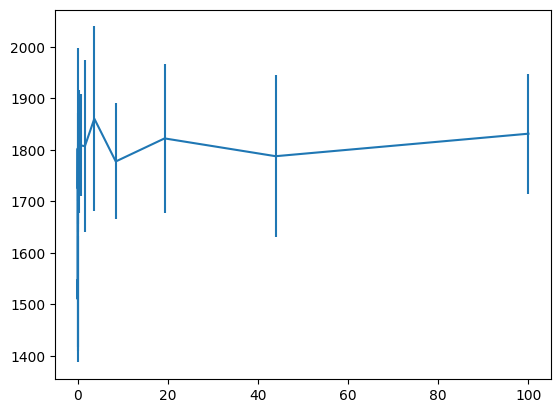

In [197]:
plt.errorbar(c_space, np.mean(np.array(profit_metrics), axis=1), yerr=np.std(np.array(profit_metrics), axis=1))
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [198]:
best_c_iters = []
for _ in range(5):
    profit_metrics = []
    for c in c_space:
        c_profit = []
        for train_fold_idx, test_fold_idx in kf.split(X):
            model = LogisticRegression(C=c, max_iter=1000).fit(X[train_fold_idx], y[train_fold_idx])
            y_pred = model.predict(X[test_fold_idx])
            c_profit.append(profit_score(y[test_fold_idx], y_pred))
        profit_metrics.append(np.array(c_profit).mean())

    best_c_iters.append(c_space[np.argmax(np.array(profit_metrics))])
        
best_c_iters

[0.31622776601683794,
 0.31622776601683794,
 0.7196856730011522,
 0.31622776601683794,
 8.483428982440726]

В силу большой дисперсии закономерности выявить закономерность сложно, каждый раз лучшим становится новый коэффициент

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ precision показывает точность, то есть для данной задачи максимизация precision включает в себя как можно больше попыток (предиктов в положительный класс), а одна из целей - как можно меньше потратить денег на работников. А вот recall тут отвечает за прибыль, а мы же хотим побольше заработать, то есть чтобы наш предикт в положительный класс оправдался и мы заработали больше долларов с человека. Максимизируя recall мы максимизируем заработок, поэтому хороший recall важнее.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [164]:
def profit_score_tune_threshold(y_true, proba, threshold):
    y_pred = proba > threshold
    return (((y_true == 1) & (y_true == y_pred)) * np.random.uniform(0, 20, size=y_true.shape)).sum() - np.sum(y_pred)


In [176]:
threshold_space = np.linspace(0, 1, 100)
threshold_profit_metrics = []

for t in threshold_space:   
    t_profit = []
    for train_fold_idx, test_fold_idx in kf.split(X):
        model = LogisticRegression(C=best_c, max_iter=1000).fit(X[train_fold_idx], y[train_fold_idx])
        proba = model.predict_proba(X[test_fold_idx])[:, 1]
        t_profit.append(profit_score_tune_threshold(y[test_fold_idx], proba, threshold=t))
    threshold_profit_metrics.append(np.array(t_profit))

best_threshold = threshold_space[np.argmax(np.array(threshold_profit_metrics).mean(axis=1))]
best_threshold

0.15151515151515152

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




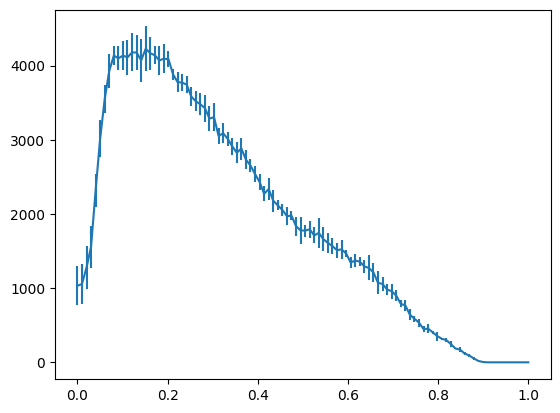

In [177]:
plt.errorbar(threshold_space, np.mean(np.array(threshold_profit_metrics), axis=1), yerr=np.std(np.array(threshold_profit_metrics), axis=1))
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ #your answer here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [200]:

def threshold_fix_precision_recall_score(y_true, preds, threshold):
    y_pred = preds > threshold
    return [precision_score(y_true, y_pred), recall_score(y_true, y_pred)]

precision = np.empty(0)
recall = np.empty(0)
for train_fold_idx, test_fold_idx in kf.split(X):
    model = LogisticRegression(C=best_c, max_iter=1000).fit(X[train_fold_idx], y[train_fold_idx])
    proba = model.predict_proba(X[test_fold_idx])[:, 1]
    prec, rec = threshold_fix_precision_recall_score(y[test_fold_idx], proba, best_threshold)
    precision = np.append(precision, prec)
    recall = np.append(recall, rec)

print(f'precision mean: {precision.mean()}, std: {precision.std()}, recall mean: {recall.mean()}, std: {recall.std()}')

precision mean: 0.3905901215776705, std: 0.014610923551860281, recall mean: 0.6017357790678215, std: 0.020590095527635296


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [203]:
threshold_space = np.linspace(0, 1, 100)

threshold_recall_metrics = []
threshold_precision_metrics = []

for t in threshold_space:   
    precision_fold, recall_fold = np.empty(0), np.empty(0) 
    for train_fold_idx, test_fold_idx in kf.split(X):
        model = LogisticRegression(C=best_c, max_iter=1000).fit(X[train_fold_idx], y[train_fold_idx])
        proba = model.predict_proba(X[test_fold_idx])[:, 1]
        
        prec, rec = threshold_fix_precision_recall_score(y[test_fold_idx], proba, threshold=t)
        precision_fold = np.append(precision_fold, prec)
        recall_fold = np.append(recall_fold, rec)

    threshold_precision_metrics.append(np.mean(precision_fold))
    threshold_recall_metrics.append(np.mean(recall_fold))


In [204]:
threshold_recall_metrics = np.array(threshold_recall_metrics)
threshold_precision_metrics = np.array(threshold_precision_metrics)

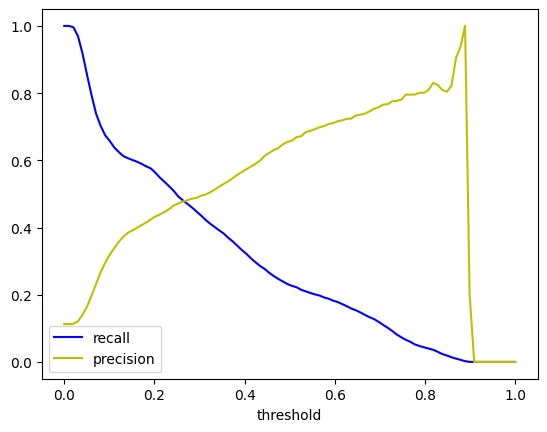

In [205]:
plt.plot(threshold_space, threshold_recall_metrics, 'b-', label='recall')
plt.plot(threshold_space, threshold_precision_metrics, 'y', label='precision')
plt.xlabel('threshold')
plt.legend(loc='best')
plt.show()

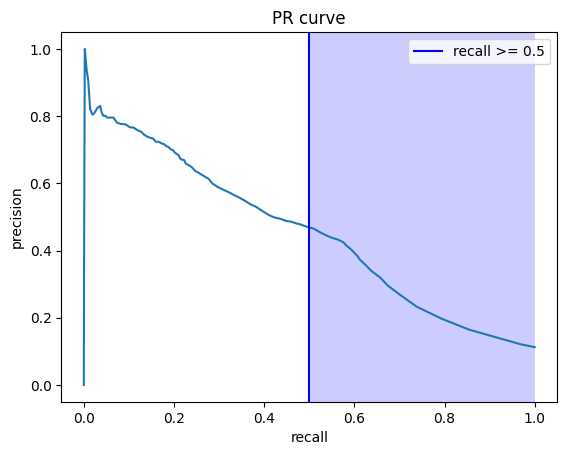

In [206]:

plt.plot(threshold_recall_metrics, threshold_precision_metrics)
plt.title('PR curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.axvline(x = 0.5, color = 'b', label = 'recall >= 0.5')
plt.axvspan(0.5, 1, facecolor='b', alpha=0.2)
plt.legend()
plt.show()

In [207]:
recall = normalize(threshold_recall_metrics[threshold_recall_metrics>0.5])
precision = normalize(threshold_precision_metrics[threshold_recall_metrics>0.5])
print('AUC-PR: ', auc(recall, precision))

AUC-PR:  0.3999735791035116


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ рассольник